
### Overview

    1. Data Exploration

    2. Data Cleaning

    3. Feature Engineering

    4. Preprocessing

    5. Model Building/Testing

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
train = pd.read_csv('/mnt/c/users/venturi/wsl/python/Kaggle/House Prices/train.csv')
test = pd.read_csv('/mnt/c/users/venturi/wsl/python/Kaggle/House Prices/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Exlploration

    1. Identify which columns have large amounts of missing values

    2. Determine shape of ditributions

In [100]:
# Create a list of columns where the percentage of missing values is 30% or greater.

[col for col in train.columns if train[col].isnull().sum()/len(train.index) > .3]

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [101]:
num_cols = train.select_dtypes('number').columns
num_cols = num_cols.drop(['Id','MSSubClass'])

In [102]:
# for col in num_cols:
#     plt.hist(train[col])
#     plt.title(col)
#     plt.show()

For columns where most entries are 0 I wanted to check the relationship between the parameter and saleprice. 

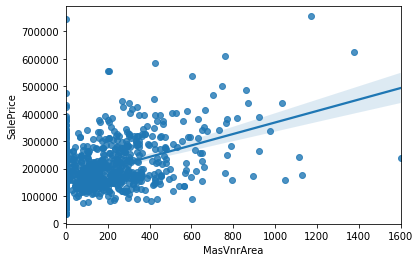

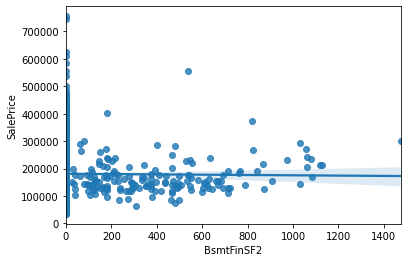

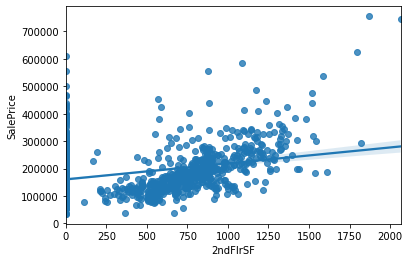

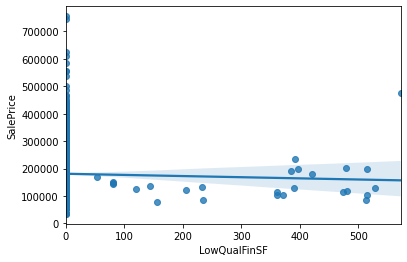

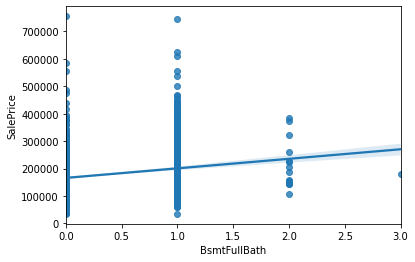

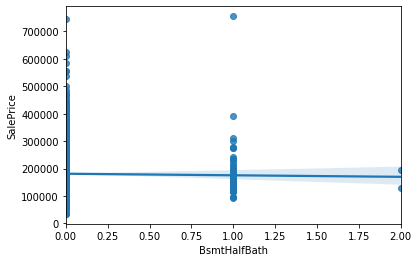

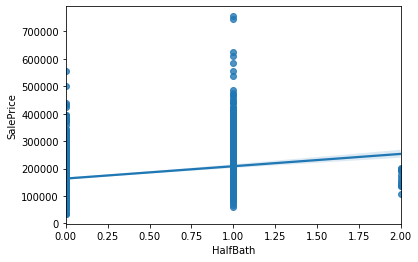

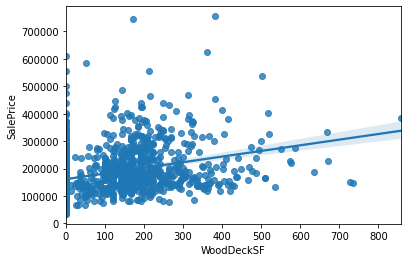

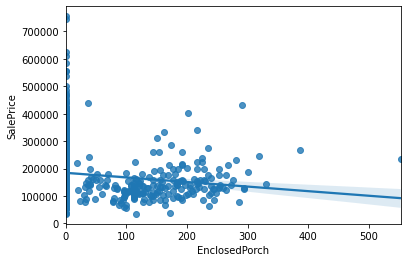

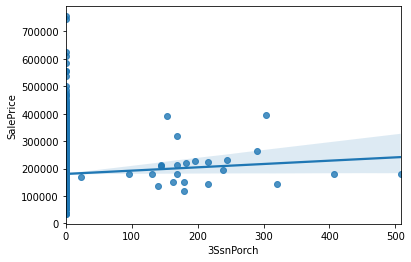

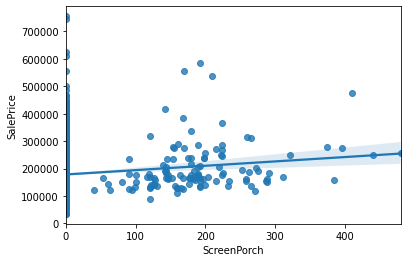

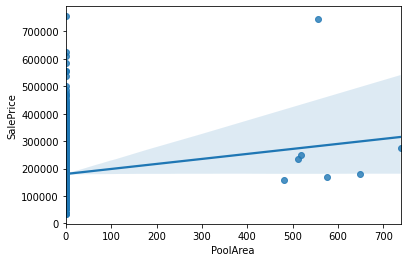

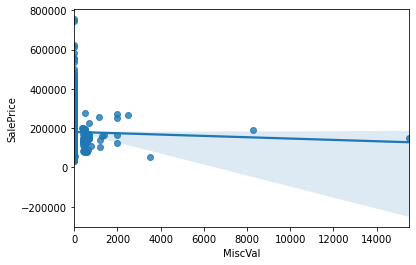

In [103]:
import seaborn as sns

areas = [col for col in num_cols if train[col].map(lambda n:n==0).sum()/len(train.index) > .5]

for col in areas:
    sns.regplot(x=col,y='SalePrice',data=train)
    plt.show()


PoolArea, MiscVal have extremely wide confidence intervals and should be dropped. 
3SsnPorch and LowQualFinSF confidence intervals are in consideration.
BsmtHalfBath, BsmtFinFinSF2 don't have a negative or positve correleation


In [104]:
# train.groupby(train['FireplaceQu'].fillna('temp')).SalePrice.describe()

In [105]:
# train.groupby('Fireplaces').SalePrice.describe()

We can see that for most of the homes that the garage was built the same year so I will choose YearBuilt to fill in missing values for GarageBlt. 

In [106]:
train.apply(lambda n: n.YearBuilt != n.GarageYrBlt if n.GarageYrBlt != 'NaN' else True, axis='columns').sum()

371

In [107]:
X = train.drop(['Alley','FireplaceQu','PoolArea','PoolQC','Fence','MiscFeature','SalePrice','PoolArea','MiscVal','BsmtHalfBath','BsmtFinSF2','3SsnPorch','LowQualFinSF'], axis=1)
y = train['SalePrice']

In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [109]:
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

categorical_cols = [col for col in X.columns if X[col].dtype == "object"]

In [110]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = RandomForestRegressor(n_estimators=1000, random_state=0)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

cv = cross_val_score(clf, X, y, cv=5)
print(cv)
print(cv.mean())

[0.87121304 0.84551161 0.87781662 0.88336937 0.81463182]
0.858508491410061


In [111]:
test = test.drop(['Alley','FireplaceQu','PoolArea','PoolQC','Fence','MiscFeature','PoolArea','MiscVal','BsmtHalfBath','BsmtFinSF2','3SsnPorch','LowQualFinSF'], axis=1)
clf.fit(X,y)
predict = clf.predict(test)

submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predict
    })
submission.to_csv('submission.csv', index=False)

In [112]:
# from xgboost import XGBRegressor

# model_2 = XGBRegressor(n_estimators=1000)
# model_2_pl = Pipeline(steps=[('preprocessor', preprocessor),
#                             ('model_2',model_2)])

# model_2_pl.fit(train_X, y)
# prediction = model_2_pl.predict(X)

# print(mean_absolute_error(y, prediction))
# print(model_2_pl.score(X,y))
